# *FORECASTING* CON REDES LSTM - PARTE 1: PREPARACIÓN DE LOS DATOS

## Contenido

1. [Introducción]
2. [El set de datos]
3. [El problema a resolver]
4. [Lectura del set de datos]
5. [Procesamiento inicial del dataset]
6. [Análisis exploratorio]
7. [Pre-procesamiento]
8. [Conclusión]

## 1. Lectura del set de datos

In [53]:
import plotly.express as px

In [54]:
#from google.colab import drive
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

# Montar Google Drive
#drive.mount('/gdrive')

# Leer set de datos
ruta = './'
datos = pd.read_csv(ruta+'Ventas_Total2.csv', delimiter=';')
#datos = pd.read_csv(ruta+'Ventas_SENSODYNEBLANQ_2016_2024.csv', delimiter=';')
#datos = pd.read_csv(ruta+'Ventas_XARELTO_2016_2024.csv', delimiter=';')

datos.tail()



,Fecha,Codigo,POS,id_item,Descripcion_larga,cantidad_unid,cantidad_frac,latitud,longitud,provincia
831192,11/4/2024 13:47,PG077,PH GYE SUPERCINES ORELLAN,88275,MICARDIS PLUS COMx80/12.5MGx28,0,7,#N/D,#N/D,#N/D
831193,11/4/2024 18:12,PG077,PH GYE SUPERCINES ORELLAN,88275,MICARDIS PLUS COMx80/12.5MGx28,0,7,#N/D,#N/D,#N/D
831194,23/4/2024 13:59,BPP27,FARMACIA BP UIO CLINICA I,88275,MICARDIS PLUS COMx80/12.5MGx28,2,0,#N/D,#N/D,#N/D
831195,23/5/2024 10:50,BPP27,FARMACIA BP UIO CLINICA I,88275,MICARDIS PLUS COMx80/12.5MGx28,1,0,#N/D,#N/D,#N/D
831196,18/6/2024 16:04,BPP27,FARMACIA BP UIO CLINICA I,88275,MICARDIS PLUS COMx80/12.5MGx28,0,7,#N/D,#N/D,#N/D


In [55]:
# datos.rename(columns={'cantidad': 'cantidad_frac'}, inplace=True)
# datos.head()
idItem = 88275

## 2. Procesamiento inicial del dataset

In [56]:
# Suponiendo que df es tu DataFrame original y quieres seleccionar solo ciertas columnas
columnas_especificas = ['Fecha', 'id_item', 'cantidad_unid','cantidad_frac']
datos = datos[columnas_especificas]
datos = datos[datos['id_item'] == idItem]


In [57]:
def validar_y_actualizar(fila):
    if  fila["cantidad_unid"] >= 1:
        if (fila['id_item'] == 13887): #JERINGA MEGA INSUL 1MLx29Gx1/2x100
          fila["cantidad_frac"] += 100 * int(fila["cantidad_unid"])
          #datos = datos = datos.rename(columns={'cantidad_unid': 'cantidad_frac'})
          #fila["cantidad_unid"] = 0
        elif fila['id_item'] in {90765, 79680, 27112, 1669, 101609, 13480}: #x'unidad  
          fila["cantidad_frac"] += int(fila["cantidad_unid"])

        elif(fila['id_item'] == 54122): #XARELTO COM-RECx10MGx10
          fila["cantidad_frac"] += 10 * int(fila["cantidad_unid"])
        
        elif(fila['id_item'] == 88275): #MICARDIX
           fila['cantidad_frac'] += 28 * int(fila["cantidad_unid"])  

    return fila


# Aplicar la función a cada fila
datos = datos.apply(validar_y_actualizar, axis=1)
datos = datos.drop(columns = ["cantidad_unid"])

### 2.1 Manipulación de fechas

In [58]:
# verificar que el tipo de dato es object 'O'
datos["Fecha"].dtype

dtype('O')

In [59]:
# Pasar la columna de Fecha al formato datetime
datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%d/%m/%Y %H:%M')
# Establecer la hora y el minuto a 0
datos['Fecha'] = datos['Fecha'].apply(lambda dt: dt.replace(hour=0, minute=0, second=0))
datos = datos.groupby(['Fecha', 'id_item'], as_index= False).sum()
# Ordenemos el dataset de forma ascendente según "fecha"
datos.sort_index(inplace=False)
datos.set_index('Fecha', inplace= True)
df = datos


## 3. Pre-procesamiento

**Se tiene 6 variables**
- *Fecha*: Fecha de compra del producto
- *codigo*: codigo de la farmacia donde se compro el producto
- *POS*: nombre de la farmacia
- *id_item*: codigo del producto
- *Descripcion_larga*: nombre del producto
- *cantidad_uni*: cantidad de producto comprada


**Tendremos dos tipos de variables al momento de implementar los modelos LSTM:**
- Variable a predecir: la variable a pronosticar (salida del modelo LSTM). En este caso es *cantidad_unid*

- Variables predictoras (o covariables): las variables de entrada al modelo LSTM a partir de las cuales se realizará la predicción.
  - Puede incluir la variable a predecir (*cantidad_unid*)
  - Puede incluir la variable tiempo (columna *Fecha*)


---



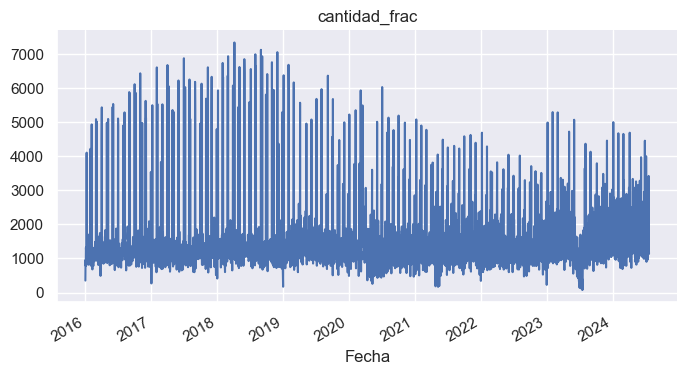

In [60]:
df['cantidad_frac'].plot(kind='line', figsize=(8, 4), title='cantidad_frac')
plt.gca().spines[['top', 'right']].set_visible(False)

**Observaciones:**
Al parecer hay varios outliers, en específico el que está a mediados del año 2022. Otro punto a considerar es que no se encuentran registros del año 2021 por motivos de pandemia es un año que se presta a valores atipicos.


---



In [61]:
# verficar datos faltantes
print('Cantidad de NaNs:')
for column in df:
    nans = df[column].isna().sum()

    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna id_item: 0
	Columna cantidad_frac: 0


garantizar que la periodicidad de las muestras es exactamente de 1 día:

In [62]:
# Convertir el índice a fecha y hora si aún no lo está
df.index = pd.to_datetime(df.index)

# Calcular diferencias (en días) entre cada par de datos consecutivos
df_time_diffs = df.index.to_series().diff().dt.days

# Contar las ocurrencias de cada diferencia
print(df_time_diffs.value_counts())

Fecha
1.0    3108
2.0       8
Name: count, dtype: int64



Por lo tanto vemos que:

- hay 2178 pares de registro con una diferencia de 1 día.
- hay 4 pares de registro con una diferencia de 2 días.
- hay 1 par de registros con una diferencia de 368 días. (la fecha de pandemia)

No hay datos faltantes
Pero debemos mejorar la perioricidad del dataset

### 3.1. Ajuste de la periodicidad del dataset


In [63]:
# Reinterpolar el dataset con una periodicidad de 1 día
#df2 = df.asfreq(freq='D', method='bfill')
df2 = df.asfreq(freq='D', method='ffill')
#df2 = df.asfreq(freq='D', fill_value=0)

# Y verificar que la totalidad del dataset tiene esta periodicidad
df_time_diffs = df2.index.to_series().diff().dt.days
print(df_time_diffs.value_counts())

Fecha
1.0    3124
Name: count, dtype: int64


In [64]:
# # Función para eliminar outliers y reemplazarlos por el valor promedio
# def eliminar_outliers(df, columnas):
#     for columna in columnas:
#         Q1 = df[columna].quantile(0.25)
#         Q3 = df[columna].quantile(0.75)
#         IQR = Q3 - Q1
#         limite_inferior = Q1 - 1.5 * IQR
#         limite_superior = Q3 + 1.5 * IQR

#         # Calcular el promedio sin outliers
#         promedio_sin_outliers = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)][columna].mean()

#         # Reemplazar los outliers por el promedio
#         df[columna] = df[columna].apply(lambda x: promedio_sin_outliers if (x < limite_inferior or x > limite_superior) else x)

#     return df

# #Seleccionar las columnas que deseas procesar
# columnas_a_procesar = ['cantidad_frac']  # Ajusta según tus necesidades

# # Aplicar la función
# df2 = eliminar_outliers(df2, columnas_a_procesar)




In [65]:
# Verificar que el dataset resultante no contiene NaNs:
print('Cantidad de NaNs:')
for column in df:
    nans = df2[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna id_item: 0
	Columna cantidad_frac: 0


In [66]:
# Y finalmente verificar las columnas originales y modificadas
for column in df:
  if pd.api.types.is_numeric_dtype(df2[column]):
    # Calcular y imprimir promedios solo para columnas flotantes
    print(f'Promedios original/modificado: {df[column].mean():.2f}/{df2[column].mean():.2f}')


Promedios original/modificado: 88275.00/88275.00
Promedios original/modificado: 1511.11/1512.38


In [67]:
df = df2

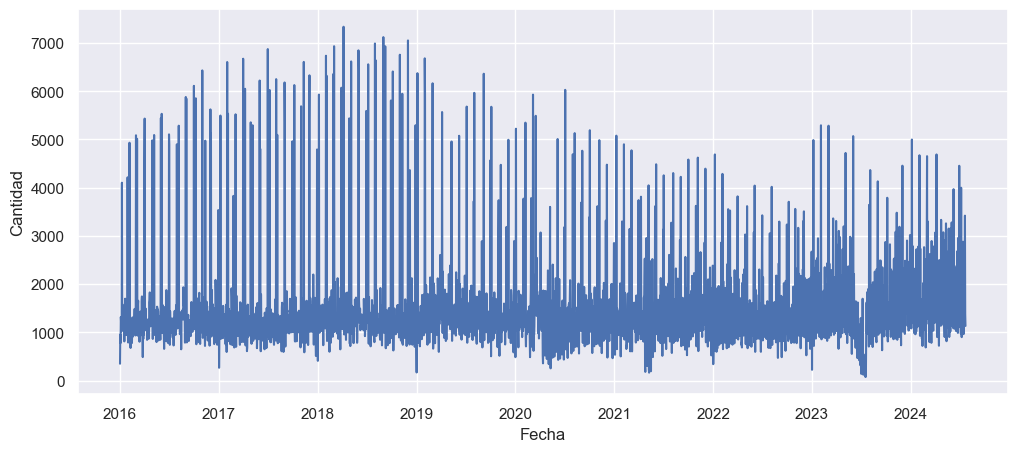

In [68]:
# Importar seaborn
import seaborn as sns
sns.set()

# Extraer la temperatura
temp = df['cantidad_frac']

# Y graficarla
fig, ax = plt.subplots(figsize=(12,5))
ax.set_ylabel('Cantidad')
sns.lineplot(temp, ax=ax);

In [69]:
var = pd.infer_freq(df.index)
print(var)

D


In [70]:

# 0. Parámetros de la serie de tiempo
N = len(temp) # Cantidad de muestras: [muestras]
muestras_dia = 1# Número de muestras/día: [muestras/día]

# 1. Calcular la magnitud de la Transformada de Fourier derecha
tf = np.abs(np.fft.rfft(temp,N))

# 2. Calcular vector frecuencias (eje horizontal)
# Ahora calculamos las frecuencias en ciclos por día
frecs = np.fft.rfftfreq(N, d=1./muestras_dia)

# 3. Graficar
# Como tenemos 1 muestra por día pero la serie dura varios años
# usaremos una escala logarítmica en el eje horizontal
fig = px.line(x=frecs, y=tf, log_x=True)
fig.update_layout(xaxis_title=f'Frecuencia (1/Día)')
fig.show()

In [71]:
frec1 = 318.1674e-6
frec2 = 954.5021e-6
frec3 = 0.2857143


print(f'La frecuencia {frec1} equivale a {1/frec1} días')
print(f'La frecuencia {frec2} equivale a {1/frec2} días')
print(f'La frecuencia {frec3} equivale a {1/frec3} días')

La frecuencia 0.0003181674 equivale a 3142.9995656374604 días
La frecuencia 0.0009545021 equivale a 1047.6666316396788 días
La frecuencia 0.2857143 equivale a 3.499999825000009 días


In [72]:
# Codificar cada combinación AAAA-MM-DD HH:MM:SS a su representación
# en segundos
tiempo_s = df.index.map(pd.Timestamp.timestamp)
tiempo_s

Index([1451606400.0, 1451692800.0, 1451779200.0, 1451865600.0, 1451952000.0,
       1452038400.0, 1452124800.0, 1452211200.0, 1452297600.0, 1452384000.0,
       ...
       1720742400.0, 1720828800.0, 1720915200.0, 1721001600.0, 1721088000.0,
       1721174400.0, 1721260800.0, 1721347200.0, 1721433600.0, 1721520000.0],
      dtype='float64', name='Fecha', length=3125)

In [73]:
# Por ejemplo, entre dos instantes de tiempo consecutivos
# habrá exactamente 3.600 segundos = 1 hora!
tiempo_s[2]-tiempo_s[1]

86400.0

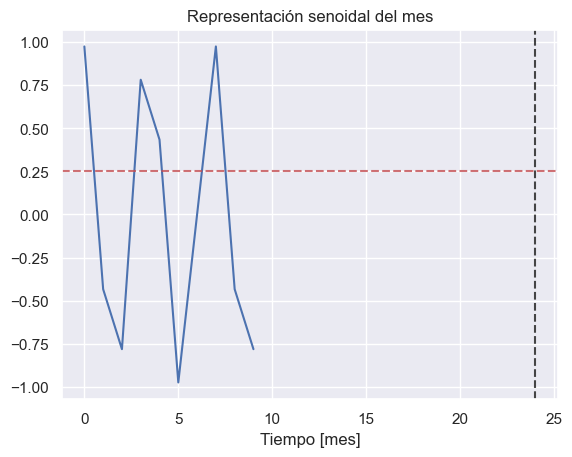

In [74]:
# Definir 1 mes en segundos como 30dias x 24 horas x 60 min x 60 s
#mes = 30*24*60*60

mes = 302400
      

# Representar el día senoidal y cosenoidalmente
# La frecuencia de la función será 1/día
mes_sin = np.sin(tiempo_s * (2 * np.pi / mes))

# Graficar 5 añós  (60 meses)
fig, ax = plt.subplots()
plt.plot(np.array(mes_sin)[:10])
plt.xlabel('Tiempo [mes]')
plt.title('Representación senoidal del mes')

# Dibujar línea horizontal en y = 0.5
ax.axhline(0.25, color='r', linestyle='--', alpha=0.8)

# Dibujar línea vertical en 24 horas
ax.axvline(24, color='k', linestyle='--', alpha=0.8);

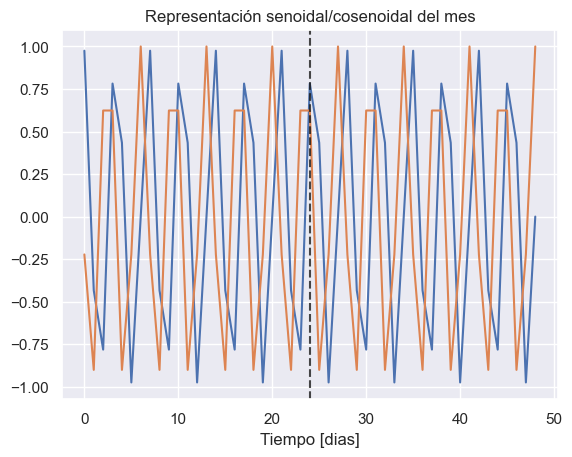

In [75]:
# Representar la hora con senos y cosenos
mes_sin = np.sin(tiempo_s * (2 * np.pi / mes))
mes_cos = np.cos(tiempo_s * (2 * np.pi / mes))

# Graficar 2 días (48 horas)
fig, ax = plt.subplots()
plt.plot(np.array(mes_sin)[:49])
plt.plot(np.array(mes_cos)[:49])
plt.xlabel('Tiempo [dias]')
plt.title('Representación senoidal/cosenoidal del mes')

# Dibujar línea vertical en 24 horas
ax.axvline(24, color='k', linestyle='--', alpha=0.8);

In [76]:
df['mes_sin'] = np.sin(tiempo_s * (2 * np.pi / mes))
df['mes_cos'] = np.cos(tiempo_s * (2 * np.pi / mes))

In [77]:
# Insertar las columnas al inicio del DataFrame
df.insert(0, 'mes_sin', df.pop('mes_sin'))
df.insert(1, 'mes_cos', df.pop('mes_cos'))


In [78]:
df.drop(columns=["id_item"], inplace=True)

In [79]:
df

,mes_sin,mes_cos,cantidad_frac
Fecha,,,
2016-01-01,9.749279e-01,-0.222521,352
2016-01-02,-4.338837e-01,-0.900969,957
2016-01-03,-7.818315e-01,0.623490,781
2016-01-04,7.818315e-01,0.623490,1321
2016-01-05,4.338837e-01,-0.900969,1194
...,...,...,...
2024-07-17,-9.749279e-01,-0.222521,1171
2024-07-18,-1.763620e-12,1.000000,1495
2024-07-19,9.749279e-01,-0.222521,3421


### En este punto ya contamos con un dataset íntegro (no contiene datos faltantes ni *outliers* y tiene una periodicidad de 1 día).
---



### 3.2. Partición del set de entrenamiento y prueba

1. Partición en train/val/test (80%, 10%, 10%)
2. Generación del dataset supervisado: entrada y salida del modelo
3. Escalamiento

A diferencia de otros modelos de Machine Learning, en el caso de series de tiempo **se debe garantizar que se generan las particiones sin mezclar aleatoriamente los datos**.

Recordemos además que:
- El set de entrenamiento (*train*) se usará para encontrar los parámetros del modelo
- El set de validación (*val*) para verificar que no haya *under/over-fitting* del modelo y para ajustar sus hiperparámetros
- El set de prueba (*test*) para poner a prueba el mejor modelo encontrado durante el entrenamiento/validación

In [80]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

#tr_size = 0.8 80% para el entrenamiento
#vl_size = 0.1 10% para la validación
#ts_size = 0.1 10% para el test



def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(df)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (2500, 3)
Tamaño set de validación: (312, 3)
Tamaño set de prueba: (313, 3)


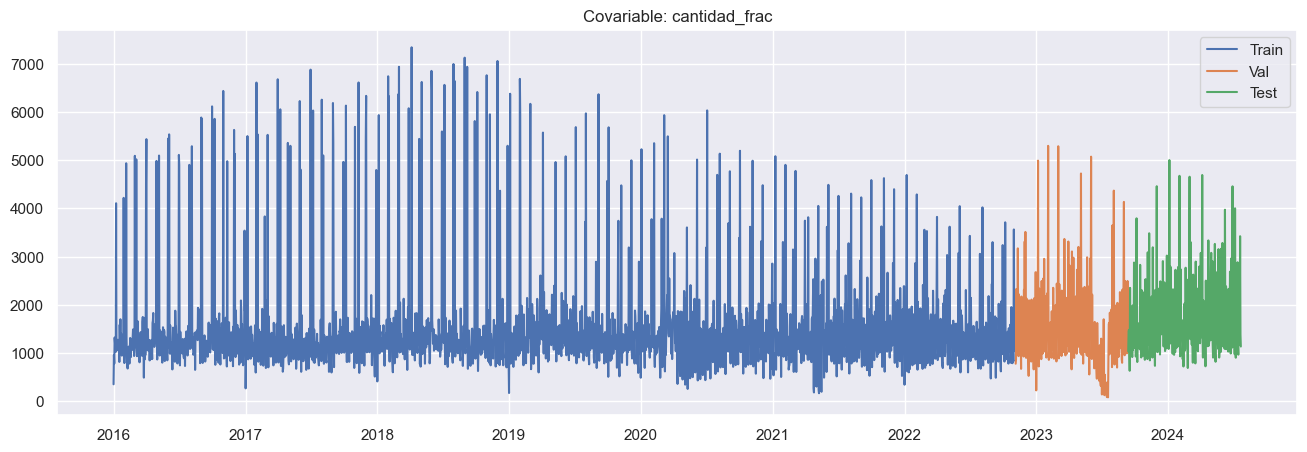

In [81]:
covar = -1 # Índice de la covariable (columna del dataset) a graficar
col = df.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.legend();

### 3.3. Generación del dataset supervisado (entrada y salida del modelo)

Debemos ajustar nuestro set de datos de acuerdo a lo especificado en la [documentación de las Redes LSTM en TensorFlow/Keras](https://www.tensorflow.)

![](https://drive.google.com/file/d/1ij9pIsJrWVYbwKrZZHY8KtNTlUs1o6AJ/view?usp=sharing)


se tiene 3 dimensiones para la entrada y salida. Como se puede ver en la figura se tiene n cantidad registros(BATCHES) que representan bloques, en la cual cada registro tiene 24 horas como periodo.

Output_lenght: numero de horas que queremos predecir a futuro.

Features(caracteristica) en este caso solo es 1 dado que nuestro modelo es univariado

Output_lenght como es un modelo unistep solo es 1


![image-3.png](attachment:image-3.png)

In [82]:
  def crear_dataset_supervisado(array, input_length, output_length):
      '''Permite crear un dataset con las entradas (X) y salidas (Y)
      requeridas por la Red LSTM.

      Parámetros:
      - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
        f: cantidad de features)
      - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
        usados para alimentar el modelo
      - output_length: instantes de tiempo a pronosticar (salida del modelo)
      '''

      # Inicialización
      X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
      shape = array.shape
      if len(shape)==1: # Si tenemos sólo una serie (univariado)
          fils, cols = array.shape[0], 1
          array = array.reshape(fils,cols)
      else: # Multivariado <-- <--- ¡esta parte de la función se ejecuta en este caso!
          fils, cols = array.shape

      # Generar los arreglos
      for i in range(fils-input_length-output_length):
          X.append(array[i:i+INPUT_LENGTH,0:cols])
          Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
      
      # Convertir listas a arreglos de NumPy
      X = np.array(X)
      Y = np.array(Y)
      
      return X, Y


In [83]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 30    # Hiperparámetro
OUTPUT_LENGTH = 3    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (2467, 30, 3), y_tr: (2467, 3, 1)
Set de validación - x_vl: (279, 30, 3), y_vl: (279, 3, 1)
Set de prueba - x_ts: (280, 30, 3), y_ts: (280, 3, 1)


### 3.4. Escalamiento
Es requerido para garantizar que todas las características se encuentran en el mismo rango de valores, lo que facilita el entrenamiento del modelo y las predicciones:

#### Detección de valores extremos usando el método de la desviación estándar
La distribución Gaussiana se caracteriza por la media (𝜇) y la desviación estándar (𝜎). Conociendo los parámetros de esta distribución podemos establecer una serie de umbrales dentro de los cuales se encontrarán distriubidos nuestros datos, así:

En el rango 𝜇±𝜎 tendremos el 68% de los datos
En el rango 𝜇±2𝜎 tendremos el 95% de los datos
En el rango 𝜇±3𝜎 tendremos el 99.7% de los datos


In [84]:
# 
# #Primero vamos a identificar el comportamiento de los outliers mediante una campana gaussiana para observar como está la distribución
# fig = px.histogram(df, x='cantidad_frac', nbins=100)
# fig.show()

#### STANDARSCALER

In [85]:
from sklearn.preprocessing import StandardScaler

def escalar_dataset(data_input):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})

    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    NFEATS = data_input['x_tr'].shape[2]


    # Generar listado con "scalers" (en este caso, por ser sólo 1 característica
    # se tendrá sólo 1 escalador)
    scalers = [StandardScaler() for i in range(NFEATS)]  # Remove feature_range
    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs: en este caso debemos garantizar que cada dato de entrada
    # a fit_transform o transform debe ser de tamaño nsamples x nfeatures
    # (en este caso 24x13)
    print('NFEATS: '+ str(NFEATS))
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0].reshape(-1,1))
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }



    return data_scaled, scalers[0]

#### ROBUSTSCALER

In [86]:
from sklearn.preprocessing import RobustScaler
import numpy as np

def escalar_dataset(data_input):
    '''Escala el dataset usando RobustScaler.

    Entradas:
    data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})

    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (en este caso, por ser sólo 1 característica
    # se tendrá sólo 1 escalador)
    scalers = [RobustScaler() for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)


    # Escalamiento Xs: en este caso debemos garantizar que cada dato de entrada
    # a fit_transform o transform debe ser de tamaño nsamples x nfeatures
    # (en este caso 30x1)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(data_input['x_tr'][:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(data_input['x_vl'][:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(data_input['x_ts'][:,:,i])

    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(data_input['y_tr'][:,:,0].reshape(-1,1))
    y_vl_s[:,:,0] = scalers[-1].transform(data_input['y_vl'][:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(data_input['y_ts'][:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]


#### MIN MAX SCALER

In [87]:
for i, col in enumerate(tr.columns):
    print(i,col)

0 mes_sin
1 mes_cos
2 cantidad_frac


In [88]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):
    '''Escala solo la columna especificada (col_ref) en el rango de -1 a 1.
    
    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: columna que contiene la variable a predecir (en este caso 'cantidad_frac')
    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''
    
    # Determinar el índice de la columna que contiene la variable a predecir
    col_index = df.columns.get_loc(col_ref)
    
    # Crear el escalador solo para la columna de interés
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Escalar solo la columna `cantidad_frac` (col_index)
    x_tr_s = data_input['x_tr'].copy()
    x_vl_s = data_input['x_vl'].copy()
    x_ts_s = data_input['x_ts'].copy()
    y_tr_s = data_input['y_tr'].copy()
    y_vl_s = data_input['y_vl'].copy()
    y_ts_s = data_input['y_ts'].copy()

    # Ajustar el escalador en los datos de entrenamiento
    x_tr_s[:, :, col_index] = scaler.fit_transform(x_tr_s[:, :, col_index])
    x_vl_s[:, :, col_index] = scaler.transform(x_vl_s[:, :, col_index])
    x_ts_s[:, :, col_index] = scaler.transform(x_ts_s[:, :, col_index])

    y_tr_s[:, :, 0] = scaler.fit_transform(y_tr_s[:, :, 0])
    y_vl_s[:, :, 0] = scaler.transform(y_vl_s[:, :, 0])
    y_ts_s[:, :, 0] = scaler.transform(y_ts_s[:, :, 0])

    # Aplicar clip para asegurar los valores dentro del rango
    x_tr_s = np.clip(x_tr_s, -1, 1)
    x_vl_s = np.clip(x_vl_s, -1, 1)
    x_ts_s = np.clip(x_ts_s, -1, 1)
    y_tr_s = np.clip(y_tr_s, -1, 1)
    y_vl_s = np.clip(y_vl_s, -1, 1)
    y_ts_s = np.clip(y_ts_s, -1, 1)

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scaler


In [89]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'cantidad_frac' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificación
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')

Min x_tr/x_vl/x_ts sin escalamiento: -0.9749279121825313/-0.9749279121824747/-0.9749279121824571
Min x_tr/x_vl/x_ts con escalamiento: -0.9999999999999999/-1.0/-0.9749279121824571

Min y_tr/y_vl/y_ts sin escalamiento: 167.0/82.0/690.0
Min y_tr/y_vl/y_ts con escalamiento: -0.9999999999999999/-1.0/-0.8541143654114365

Max x_tr/x_vl/x_ts sin escalamiento: 7337.0/5294.0/4999.0
Max x_tr/x_vl/x_ts con escalamiento: 1.0/1.0/1.0

Max y_tr/y_vl/y_ts sin escalamiento: 7337.0/5294.0/4999.0
Max y_tr/y_vl/y_ts con escalamiento: 1.0/0.43012552301255247/0.3478382147838215


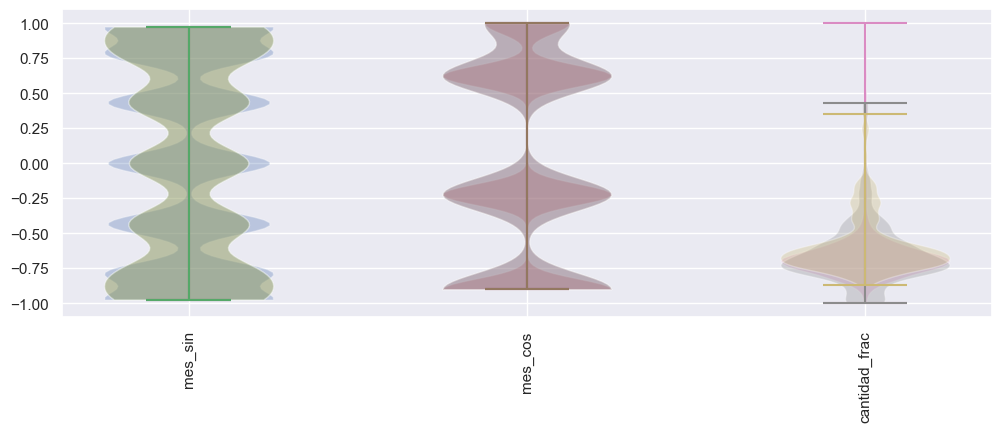

In [90]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

fig, ax = plt.subplots(figsize=(12,4))
for i in range(3):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(3)))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale();

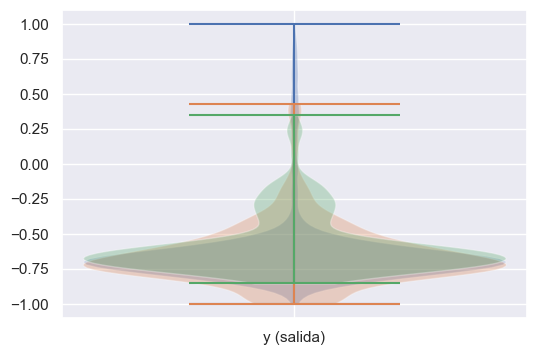

In [91]:
# Y hagamos lo mismo con la variable de salida:
fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida)']);

In [92]:
import pickle

# Escalamiento del dataset
data_s, scaler = escalar_dataset(data_in, 'cantidad_frac')

# Guardar el scaler en un archivo .pkl
with open(f'scaler_{idItem}.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## 4. Creación y entrenamieto del Modelo

### 4.1 DROPOUT

In [49]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Dense, Dropout

import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 129 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 24 (días) x 1 (feature)
DROPOUT_RATE = 0.1  # Tasa de dropout (ajústala según tus necesidades)


modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE, return_sequences=True)) # 'return_sequences=True' para añadir más capas LSTM
modelo.add(Dropout(DROPOUT_RATE))  # Agregar capa Dropout


# Segunda capa LSTM
modelo.add(LSTM(N_UNITS, return_sequences=True))  # Mantener return_sequences para permitir agregar más capas
modelo.add(Dropout(DROPOUT_RATE))  # Segunda capa Dropout


# Tercera capa LSTM (sin return_sequences ya que es la última LSTM)
modelo.add(LSTM(N_UNITS))
modelo.add(Dropout(DROPOUT_RATE))  # Tercera capa Dropout

modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)


# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Pérdida: se usará el MAE (mean absolute error) para el entrenamiento
# pues permite medir el error absoluto promedio
def mean_absolute_error(y_true, y_pred):
    mae = tf.math.reduce_mean(tf.abs(y_pred - y_true))
    return mae

# Compilar el modelo con RMSE como función de pérdida
optimizador = Adam(learning_rate=0.0002) #0.0002 5e-5
modelo.compile(
    optimizer=optimizador,
    loss=root_mean_squared_error,  # Pérdida RMSE
    #metrics=[root_mean_squared_error, 'mean_absolute_error']  # Métricas adicionales
)




In [93]:
# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 20 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/20
10/10 - 2s - 171ms/step - loss: 0.2874 - val_loss: 0.2320
Epoch 2/20
10/10 - 2s - 156ms/step - loss: 0.2881 - val_loss: 0.2317
Epoch 3/20
10/10 - 2s - 154ms/step - loss: 0.2883 - val_loss: 0.2314
Epoch 4/20
10/10 - 2s - 154ms/step - loss: 0.2869 - val_loss: 0.2310
Epoch 5/20
10/10 - 1s - 130ms/step - loss: 0.2859 - val_loss: 0.2307
Epoch 6/20
10/10 - 1s - 147ms/step - loss: 0.2856 - val_loss: 0.2304
Epoch 7/20
10/10 - 1s - 142ms/step - loss: 0.2857 - val_loss: 0.2301
Epoch 8/20
10/10 - 1s - 141ms/step - loss: 0.2856 - val_loss: 0.2298
Epoch 9/20
10/10 - 1s - 134ms/step - loss: 0.2847 - val_loss: 0.2295
Epoch 10/20
10/10 - 1s - 137ms/step - loss: 0.2834 - val_loss: 0.2291
Epoch 11/20
10/10 - 1s - 137ms/step - loss: 0.2835 - val_loss: 0.2286
Epoch 12/20
10/10 - 1s - 135ms/step - loss: 0.2827 - val_loss: 0.2276
Epoch 13/20
10/10 - 1s - 141ms/step - loss: 0.2814 - val_loss: 0.2259
Epoch 14/20
10/10 - 2s - 157ms/step - loss: 0.2790 - val_loss: 0.2212
Epoch 15/20
10/10 - 2s - 171m

In [45]:
# Entrenar el modelo
EPOCHS = 10
BATCH_SIZE = 256
historia = modelo.fit(
    x=x_tr_s,
    y=y_tr_s.reshape((y_tr_s.shape[0], OUTPUT_LENGTH)),  # Aplanar las salidas a 2D
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_vl_s, y_vl_s.reshape((y_vl_s.shape[0], OUTPUT_LENGTH))),  # Aplanar las salidas de validación
    verbose=2
)

Epoch 1/10
10/10 - 6s - 564ms/step - loss: 0.6488 - mean_absolute_error: 0.6205 - root_mean_squared_error: 0.6438 - val_loss: 0.4323 - val_mean_absolute_error: 0.3956 - val_root_mean_squared_error: 0.4472
Epoch 2/10
10/10 - 1s - 141ms/step - loss: 0.2857 - mean_absolute_error: 0.2322 - root_mean_squared_error: 0.2837 - val_loss: 0.2806 - val_mean_absolute_error: 0.1628 - val_root_mean_squared_error: 0.2779
Epoch 3/10
10/10 - 1s - 147ms/step - loss: 0.2094 - mean_absolute_error: 0.1632 - root_mean_squared_error: 0.2090 - val_loss: 0.2697 - val_mean_absolute_error: 0.1695 - val_root_mean_squared_error: 0.2717
Epoch 4/10
10/10 - 2s - 157ms/step - loss: 0.1911 - mean_absolute_error: 0.1299 - root_mean_squared_error: 0.1910 - val_loss: 0.2702 - val_mean_absolute_error: 0.1709 - val_root_mean_squared_error: 0.2736
Epoch 5/10
10/10 - 1s - 149ms/step - loss: 0.1883 - mean_absolute_error: 0.1350 - root_mean_squared_error: 0.1883 - val_loss: 0.2726 - val_mean_absolute_error: 0.1615 - val_root_me

KeyError: 'root_mean_squared_error'

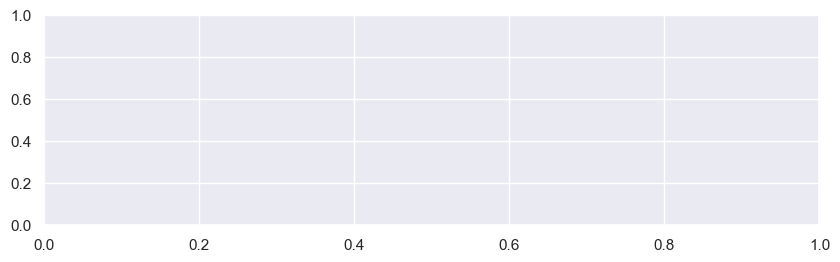

In [134]:
# Graficar RMSE y MAE durante el entrenamiento
plt.figure(figsize=(10, 6))

# Graficar el RMSE
plt.subplot(2, 1, 1)
plt.plot(historia.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(historia.history['val_root_mean_squared_error'], label='Val RMSE')
plt.title(f'RMSE durante el entrenamiento y validación {idItem}')
plt.ylabel('RMSE')
plt.legend()

# Graficar el MAE
plt.subplot(2, 1, 2)
plt.plot(historia.history['mean_absolute_error'], label='Train MAE')
plt.plot(historia.history['val_mean_absolute_error'], label='Val MAE')
plt.title(f'MAE durante el entrenamiento y validación {idItem}')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [94]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['mean_absolute_error'],label=f'Train Loss with Dropout {DROPOUT_RATE}:, item= {idItem}')
plt.plot(historia.history['val_mean_absolute_error'],label=f'Val Loss with Dropout , item= {idItem}')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

KeyError: 'mean_absolute_error'

Epoch 1/50
10/10 - 0s - 26ms/step - loss: 0.2212 - mean_absolute_error: 0.1501 - root_mean_squared_error: 0.2212 - val_loss: 0.1569 - val_mean_absolute_error: 0.1228 - val_root_mean_squared_error: 0.1405
Epoch 2/50
10/10 - 0s - 20ms/step - loss: 0.2212 - mean_absolute_error: 0.1501 - root_mean_squared_error: 0.2212 - val_loss: 0.1570 - val_mean_absolute_error: 0.1229 - val_root_mean_squared_error: 0.1406
Epoch 3/50
10/10 - 0s - 23ms/step - loss: 0.2212 - mean_absolute_error: 0.1501 - root_mean_squared_error: 0.2211 - val_loss: 0.1570 - val_mean_absolute_error: 0.1229 - val_root_mean_squared_error: 0.1406
Epoch 4/50
10/10 - 0s - 20ms/step - loss: 0.2211 - mean_absolute_error: 0.1500 - root_mean_squared_error: 0.2211 - val_loss: 0.1571 - val_mean_absolute_error: 0.1230 - val_root_mean_squared_error: 0.1407
Epoch 5/50
10/10 - 0s - 21ms/step - loss: 0.2211 - mean_absolute_error: 0.1500 - root_mean_squared_error: 0.2211 - val_loss: 0.1571 - val_mean_absolute_error: 0.1231 - val_root_mean_sq

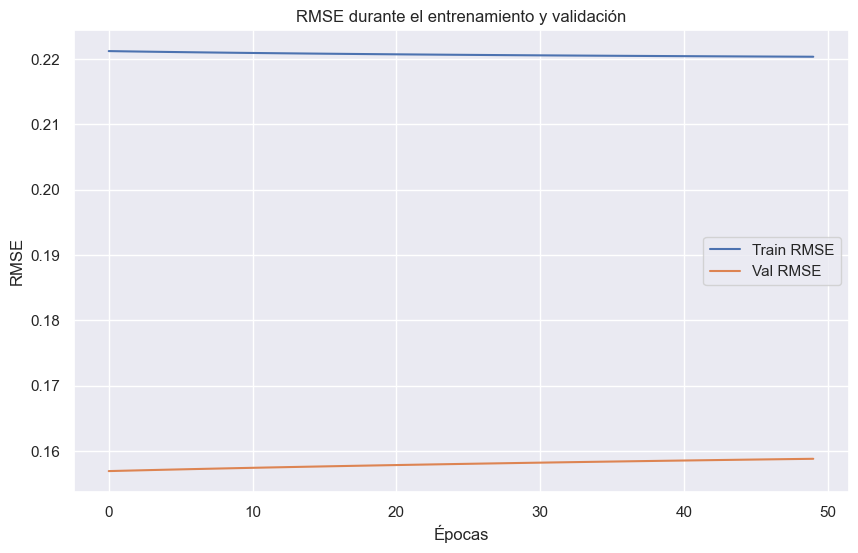

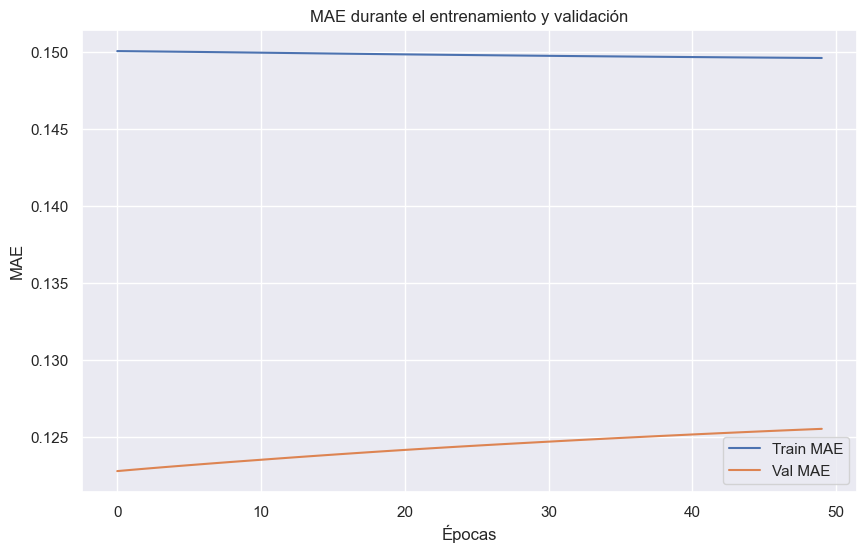

In [ ]:
# Entrenamiento del modelo
# Ajustar las formas de las salidas
y_tr_s = y_tr_s.reshape((y_tr_s.shape[0], OUTPUT_LENGTH))  # Aplanar las salidas de entrenamiento
y_vl_s = y_vl_s.reshape((y_vl_s.shape[0], OUTPUT_LENGTH))  # Aplanar las salidas de validación

# Entrenar el modelo
EPOCHS = 50  # Número de épocas
BATCH_SIZE = 256  # Tamaño del lote
historia = modelodr.fit(
    x=x_tr_s,
    y=y_tr_s,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_vl_s, y_vl_s),
    verbose=2
)

# Graficar las curvas de entrenamiento para verificar si hay bias

plt.figure(figsize=(10, 6))

# Gráfico de loss (RMSE) para entrenamiento y validación
plt.plot(historia.history['loss'], label='Train RMSE')
plt.plot(historia.history['val_loss'], label='Val RMSE')
plt.title('RMSE durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('RMSE')
plt.legend()

# Gráfico del MAE para complementar la evaluación
plt.figure(figsize=(10, 6))
plt.plot(historia.history['mean_absolute_error'], label='Train MAE')
plt.plot(historia.history['val_mean_absolute_error'], label='Val MAE')
plt.title('MAE durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.show()

### 4.2 SIN DROPOUT

In [ ]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 24 (horas) x 17 (features)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

# Y lo único que cambia con respecto al modelo multivariado + multi-step es
# el tamaño deldato de salida (4 horas)
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Pérdida: se usará el MAE (mean absolute error) para el entrenamiento
# pues permite medir el error absoluto promedio
def mean_absolute_error(y_true, y_pred):
    mae = tf.math.reduce_mean(tf.abs(y_pred - y_true))
    return mae

# Compilar el modelo con RMSE como función de pérdida
optimizador = Adam(learning_rate=0.0002) #0.0002 5e-5
modelo.compile(
    optimizer=optimizador,
    loss=root_mean_squared_error,  # Pérdida RMSE
    metrics=[root_mean_squared_error, 'mean_absolute_error']  # Métricas adicionales
)

# Entrenar el modelo
EPOCHS = 30
BATCH_SIZE = 256
historia = modelo.fit(
    x=x_tr_s,
    y=y_tr_s.reshape((y_tr_s.shape[0], OUTPUT_LENGTH)),  # Aplanar las salidas a 2D
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_vl_s, y_vl_s.reshape((y_vl_s.shape[0], OUTPUT_LENGTH))),  # Aplanar las salidas de validación
    verbose=2
)

Epoch 1/30


c:\Users\jeanf\miniconda3\envs\streamlit\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



10/10 - 2s - 182ms/step - loss: 0.6284 - mean_absolute_error: 0.5880 - root_mean_squared_error: 0.6280 - val_loss: 0.5207 - val_mean_absolute_error: 0.4826 - val_root_mean_squared_error: 0.5389
Epoch 2/30
10/10 - 0s - 39ms/step - loss: 0.6049 - mean_absolute_error: 0.5648 - root_mean_squared_error: 0.6044 - val_loss: 0.5006 - val_mean_absolute_error: 0.4620 - val_root_mean_squared_error: 0.5183
Epoch 3/30
10/10 - 0s - 37ms/step - loss: 0.5810 - mean_absolute_error: 0.5412 - root_mean_squared_error: 0.5806 - val_loss: 0.4800 - val_mean_absolute_error: 0.4408 - val_root_mean_squared_error: 0.4972
Epoch 4/30
10/10 - 0s - 37ms/step - loss: 0.5562 - mean_absolute_error: 0.5166 - root_mean_squared_error: 0.5558 - val_loss: 0.4580 - val_mean_absolute_error: 0.4182 - val_root_mean_squared_error: 0.4747
Epoch 5/30
10/10 - 0s - 35ms/step - loss: 0.5291 - mean_absolute_error: 0.4896 - root_mean_squared_error: 0.5286 - val_loss: 0.4336 - val_mean_absolute_error: 0.3932 - val_root_mean_squared_erro

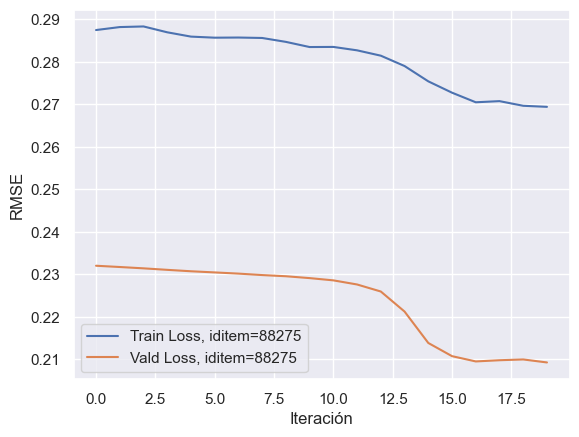

In [96]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label=f'Train Loss, iditem={idItem}')
plt.plot(historia.history['val_loss'],label=f'Vald Loss, iditem={idItem}')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

## GUARDAR MODELO

In [147]:
# Guardar el modelo entrenado
modelo.save(f'modelo_{idItem}.keras')
#modelo.save(f'modelo_{idItem}.keras')

# CARGAR MODELO 1

In [150]:
# def preparar_datos_para_prediccion(df, id_item, input_length, output_length, scaler, modelo):
#     """
#     Predice los valores de los próximos días a partir del último registro en el DataFrame.

#     Args:
#     df (pd.DataFrame): DataFrame que contiene las columnas 'fecha', 'id_item', 'cantidad_frac'.
#     id_item (int/str): El ID del item para el cual se quieren hacer predicciones.
#     input_length (int): El número de registros que el modelo necesita como entrada.
#     output_length (int): El número de días a predecir.
#     scaler: El objeto MinMaxScaler que se usó para escalar los datos durante el entrenamiento.
#     modelo: El modelo LSTM cargado para hacer predicciones.

#     Returns:
#     np.array: Predicciones desescaladas para los próximos días.
#     """
#     # Suponiendo que df es tu DataFrame original y quieres seleccionar solo ciertas columnas
#     columnas_especificas = ['Fecha', 'id_item','cantidad_unid', 'cantidad_frac']
#     df = df[columnas_especificas]


#     # Filtrar el DataFrame para el id_item deseado
#     df_item = df[df['id_item'] == id_item].copy()

#     # Ordenar por fecha y tomar los últimos 'input_length' registros
#     df_item = df_item.sort_values(by='Fecha').tail(input_length)

#     # Asegurarse de que los datos estén en el formato correcto (n_samples, input_length, n_features)
#     datos = df_item['cantidad_frac'].values.reshape(-1, 1)

#     # Crear un array con las características que espera el scaler (relleno con ceros)
#     datos_expandidos = np.zeros((input_length, scaler.n_features_in_))
#     datos_expandidos[:, 0] = datos[:, 0]  # Copiar los valores en la primera columna

#     # Escalar los datos
#     datos_escalados = scaler.transform(datos_expandidos)

#     # Seleccionar solo la primera columna escalada para la predicción
#     datos_escalados = datos_escalados[:, 0].reshape(1, input_length, 1)

#     predicciones = []

#     # Iterativamente predecir los próximos días
#     for _ in range(output_length):
#         # Hacer la predicción
#         prediccion = modelo.predict(datos_escalados)

#         # Crear un array expandido para desescalado
#         prediccion_expandidas = np.zeros((prediccion.shape[0], scaler.n_features_in_))
#         prediccion_expandidas[:, 0] = prediccion[:, 0]

#         # Invertir el escalado de la predicción
#         prediccion_invertida = scaler.inverse_transform(prediccion_expandidas)

#         # Agregar la primera columna a las predicciones finales
#         predicciones.append(prediccion_invertida[0, 0])

#         # Añadir la nueva predicción a los datos para predecir el siguiente día
#         nueva_entrada = prediccion[0, 0].reshape(1, 1, 1)
#         datos_escalados = np.append(datos_escalados[:, 1:, :], nueva_entrada, axis=1)

#     return np.array(predicciones)


In [151]:

# # Ejemplo de uso:
# id_item = 13887  # Reemplaza con tu id_item específico
# input_length = 24  # Este es el valor que usaste para entrenar tu modelo
# output_length = 5  # Los 5 días que quieres predecir

# # Realizar las predicciones
# predicciones_5_dias = preparar_datos_para_prediccion(df3, id_item, input_length, output_length, scaler_cargado, modelo_cargado)

# print("Predicciones para los próximos 5 días:", predicciones_5_dias)

# CARGAR MODELO 2

In [152]:
from datetime import timedelta
from tensorflow.keras.models import load_model

# Función para hacer predicciones
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x, verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

# Cargar el modelo guardado en formato Keras
modelo_cargado = load_model(f'modelo_{idItem}.keras', custom_objects={'root_mean_squared_error': root_mean_squared_error})

# Obtener la última fecha del conjunto de datos
ultima_fecha = df.index[-1]

# Generar un rango de fechas futuras
num_predicciones = 4  # Número de días a predecir
fechas_futuras = [ultima_fecha + timedelta(days=i) for i in range(1, num_predicciones + 1)]

# Preparar el último segmento del conjunto de datos de entrada desde el conjunto de test
# Este segmento ahora incluye también las características adicionales (día, mes, año)
ultimo_segmento = ts[-INPUT_LENGTH:].values
ultimo_segmento = ultimo_segmento.reshape((1, INPUT_LENGTH, ts.shape[1]))  # Ajustado para múltiples features

# Obtener las predicciones futuras usando el modelo cargado
predicciones_futuras = []
segmento_actual = ultimo_segmento

for _ in range(num_predicciones):
    prediccion = predecir(segmento_actual, modelo_cargado, scaler)
    predicciones_futuras.append(prediccion[0])

    # Actualizar el segmento actual con el nuevo valor predicho
    nuevo_valor = np.array(prediccion[0]).reshape(1, 1, 1)
    # Aquí se necesitaría también actualizar las características de día, mes, año del nuevo valor
    nuevo_segmento = np.array([fechas_futuras[-1].day, fechas_futuras[-1].month, fechas_futuras[-1].year]).reshape(1, 1, 3)
    segmento_actual = np.append(segmento_actual[:, 1:, :], np.hstack((nuevo_valor, nuevo_segmento)), axis=1)

# Crear un DataFrame con las predicciones futuras y sus fechas
resultados_futuros = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Predicción': predicciones_futuras
})

# Visualizar las predicciones
print(resultados_futuros)

# Si estás usando Streamlit, podrías mostrarlo así:
# st.write(resultados_futuros)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 1 and the array at index 1 has size 3

In [ ]:
# from tensorflow.keras.models import load_model
# from datetime import timedelta
# import pandas as pd
# import numpy as np

# def predecir_con_modelo(df, modelo, scaler, input_length, num_predicciones, id_item):
#     """
#     Transforma un DataFrame y genera predicciones futuras utilizando un modelo LSTM cargado.

#     Args:
#     df (pd.DataFrame): DataFrame que contiene las columnas 'fecha', 'id_item', 'cantidad_frac'.
#     modelo: Modelo LSTM cargado desde un archivo .keras.
#     scaler: Objeto MinMaxScaler utilizado para escalar los datos.
#     input_length (int): Número de registros que el modelo necesita como entrada.
#     num_predicciones (int): Número de días a predecir.
#     id_item (int/str): El ID del item para el cual se quieren hacer predicciones.

#     Returns:
#     pd.DataFrame: DataFrame con las fechas futuras y sus correspondientes predicciones.
#     """

#     # Filtrar el DataFrame para el id_item deseado
#     df_item = df[df['id_item'] == id_item].copy()

#     # Obtener la última fecha del conjunto de datos
#     ultima_fecha = df_item['Fecha'].max()

#     # Asegúrate de que 'ultima_fecha' sea un objeto datetime
#     if isinstance(ultima_fecha, str):
#         # Si es una cadena, conviértela a datetime
#         # (Asumiendo que el formato de fecha es 'YYYY-MM-DD')
#         ultima_fecha = pd.to_datetime(ultima_fecha)

#     # Generar un rango de fechas futuras
#     fechas_futuras = [ultima_fecha + timedelta(days=i) for i in range(1, num_predicciones + 1)]


#     # Preparar el último segmento del conjunto de datos de entrada
#     ultimo_segmento = df_item['cantidad_frac'].values[-input_length:]
#     ultimo_segmento = ultimo_segmento.reshape((1, input_length, 1))

#     # Escalar el último segmento
#     ultimo_segmento_escalado = np.zeros((input_length, scaler.n_features_in_))
#     ultimo_segmento_escalado[:, 0] = ultimo_segmento[:, 0, 0]
#     ultimo_segmento_escalado = scaler.transform(ultimo_segmento_escalado)
#     segmento_actual = ultimo_segmento_escalado[:, 0].reshape(1, input_length, 1)

#     # Obtener las predicciones futuras usando el modelo cargado
#     predicciones_futuras = []

#     for _ in range(num_predicciones):
#         prediccion = modelo.predict(segmento_actual, verbose=0)

#         # Desescalar la predicción
#         prediccion_expandidas = np.zeros((prediccion.shape[0], scaler.n_features_in_))
#         prediccion_expandidas[:, 0] = prediccion[:, 0]
#         prediccion_invertida = scaler.inverse_transform(prediccion_expandidas)

#         # Agregar la primera columna a las predicciones finales
#         predicciones_futuras.append(prediccion_invertida[0, 0])

#         # Actualizar el segmento actual
#         nuevo_valor = prediccion[0, 0].reshape(1, 1, 1)
#         segmento_actual = np.append(segmento_actual[:, 1:, :], nuevo_valor, axis=1)

#     # Crear un DataFrame con las predicciones futuras y sus fechas
#     resultados_futuros = pd.DataFrame({
#         'Fecha': fechas_futuras,
#         'Predicción': predicciones_futuras
#     })

#     return resultados_futuros

# # Ejemplo de uso:
# #df = pd.read_csv('tu_archivo.csv')  # Reemplaza con tu archivo de datos
# input_length = 24  # Este es el valor que usaste para entrenar tu modelo
# num_predicciones = 4  # Número de días a predecir
# id_item =13887  # Reemplaza con tu id_item específico

# # Cargar el modelo guardado en formato Keras
# modelo_cargado = load_model('modelo_ventas_insulina.keras', custom_objects={'root_mean_squared_error': root_mean_squared_error})

# # Generar las predicciones usando la función
# resultados_futuros = predecir_con_modelo(df3, modelo_cargado, scaler, input_length, num_predicciones, id_item)

print(resultados_futuros)


       Fecha  Predicción
0 2024-08-09  336.840668
1 2024-08-10  328.040131
2 2024-08-11  335.017212
3 2024-08-12  334.722198


In [ ]:
# print("Número de dimensiones:", resultados_futuros.ndim)
# print("Forma del arreglo:", resultados_futuros.shape)
# print("Número total de elementos:", resultados_futuros.size)

# DESEMPEÑO DEL MODELO

In [95]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print(f'Comparativo desempeños {idItem}:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños 88275:
  RMSE train:	 0.256
  RMSE val:	 0.208
  RMSE test:	 0.196


Los desempeños son comparables lo cual quiere decir que el modelo generaliza bastante bien.

ValueError: x and y must be the same size

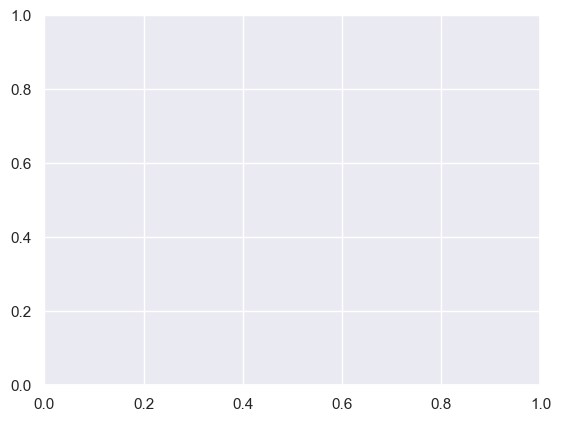

In [360]:
# 1. Generar las predicciones sobre el set de prueba
y_ts_pred_s = modelo.predict(x_ts_s, verbose=0)

# 2. Realizar la transformación inversa de las predicciones para llevar sus
# valores a la escala original
y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

# 3. Calcular RMSE para cada instante de tiempo predicho
diff_cuad = np.square((y_ts.squeeze())-y_ts_pred) # BATCHESx4
proms = np.mean(diff_cuad, axis=0) # 1x4
rmse = np.sqrt(proms) # 1x4

# Graficar rmse para cada timestep
t = np.linspace(1,4,4)

fig, ax = plt.subplots()
ax.scatter(t,rmse)
ax.set_xlabel('Dia predicho')
ax.set_ylabel('Error RMSE')
ax.set_title(f'Desempeño set de Prueba {idItem}')
plt.xticks(ticks=t, labels=t)
plt.grid();

In [ ]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [ ]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelodr, scaler)

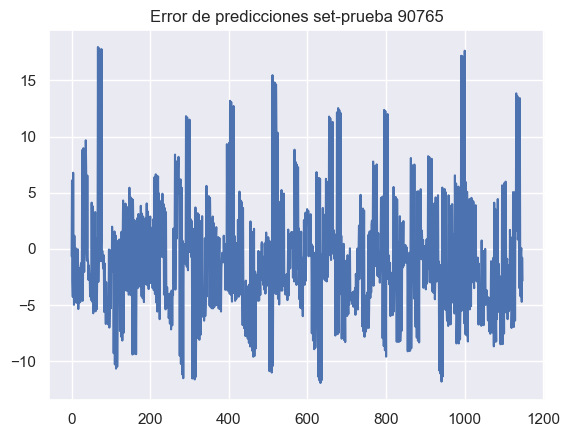

In [ ]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = (y_ts.flatten()-y_ts_pred)
plt.title(f'Error de predicciones set-prueba {idItem}')
plt.plot(errores);

In [ ]:
 from datetime import timedelta

# Obtener la última fecha del conjunto de datos
ultima_fecha = df.index[-1]

# Generar un rango de fechas futuras
num_predicciones = 4  # Número de días a predecir
fechas_futuras = [ultima_fecha + timedelta(days=i) for i in range(1, num_predicciones + 1)]

# Preparar el último segmento del conjunto de datos de entrada desde el conjunto de test
ultimo_segmento = ts[-INPUT_LENGTH:].values
ultimo_segmento = ultimo_segmento.reshape((1, INPUT_LENGTH, 3))

# Obtener las predicciones futuras
predicciones_futuras = []
segmento_actual = ultimo_segmento.copy()  # Create a copy to avoid modifying the original

for _ in range(num_predicciones):
    prediccion = predecir(segmento_actual, modelo, scaler)
    predicciones_futuras.append(prediccion[0])

    # Actualizar el segmento actual - Instead of appending and slicing,
    # shift the values and insert the new prediction at the end
    segmento_actual = np.roll(segmento_actual, -1, axis=1)
    segmento_actual[0,-1,0] = prediccion[0]

# Crear un DataFrame con las predicciones futuras y sus fechas
resultados_futuros = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Predicción': predicciones_futuras
})

resultados_futuros.set_index('Fecha', inplace=True)


In [ ]:
print(resultados_futuros)

            Predicción
Fecha                 
2024-08-08   77.061119
2024-08-09   61.960026
2024-08-10   33.560558
2024-08-11   19.071920
